In [1]:
import numpy as np
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import optuna

np.random.seed(1729)

/home/mgsilva/miniconda3/envs/torch_motifpredenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from torch import nn
import torch.optim as optim

torch.manual_seed(1729)
x = torch.rand(5, 3)
print(x)

tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691],
        [0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938],
        [0.6128, 0.1519, 0.0453]])


In [3]:
from torch.nn.utils.rnn import pad_sequence

def create_dataset(data, variable_indexes, lookback_period, step, forecast_period, motif_indexes):
    X1, X2, y = [], [], []  # X1: data, X2: indexes of the motifs, y: distance to the next motif
    
    for idx in range(len(data[0]) - lookback_period - 1):
        if idx % step != 0:
            continue

        window_end_idx = idx + lookback_period
        forecast_period_end = window_end_idx + forecast_period

        # If there are no more matches after the window, break
        if not any([window_end_idx < motif_idx for motif_idx in motif_indexes]):
            break

        # Motif indexes in window, relative to the start of the window
        motif_indexes_in_window = [motif_idx - idx for motif_idx in motif_indexes if idx <= motif_idx <= window_end_idx]
        motif_indexes_in_forecast_period = [motif_idx for motif_idx in motif_indexes if window_end_idx < motif_idx <= forecast_period_end]

        if motif_indexes_in_forecast_period:
            next_match_in_forecast_period = motif_indexes_in_forecast_period[0]
        else:
            next_match_in_forecast_period = -1  # No match in the forecast period but exists in the future

        # Get the data window and transpose to (lookback_period, num_features)
        data_window = data[variable_indexes, idx:window_end_idx].T

        # Calculate `y`
        data_y = -1
        if next_match_in_forecast_period != -1:
            # Index of the next match relative to the end of the window
            data_y = next_match_in_forecast_period - window_end_idx
        
        # Append to lists
        X1.append(torch.tensor(data_window, dtype=torch.float32))  # Now with shape (lookback_period, num_features)
        X2.append(torch.tensor(motif_indexes_in_window, dtype=torch.long)) 
        y.append(data_y) 

    # Pad X2 sequences to have the same length
    X2_padded = pad_sequence(X2, batch_first=True, padding_value=-1)
    
    # Convert lists to torch tensors
    X1 = torch.stack(X1)  # Final shape: (num_samples, lookback_period, num_features)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(1) 

    return X1, X2_padded, y


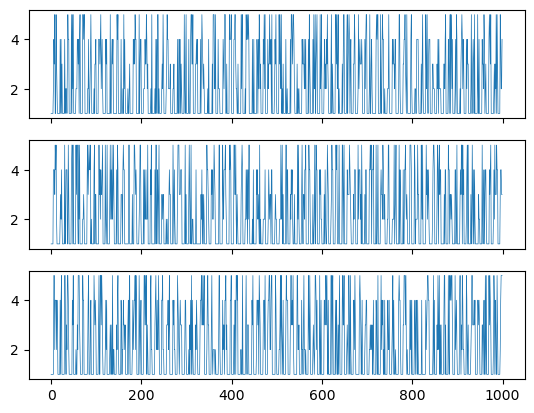

In [4]:
#load data
#fixed frequency repetitions
n = 1000
k = 3
variable_indexes = range(k)

data_scenario1 = np.genfromtxt("../data/syntheticdata/scenario1_k=3.csv", delimiter=",")
data_scenario1 = data_scenario1.astype(int)
data_scenario1 = data_scenario1.reshape((k, n))

motif_indexes_scenario1 = np.genfromtxt("../data/syntheticdata/motif_indexes_scenario1_k=3.csv", delimiter=",")
motif_indexes_scenario1= motif_indexes_scenario1.astype(int)

fig, axs = plt.subplots(k, 1, sharex=True)
for i in range(k):
    axs[i].plot(data_scenario1[i], linewidth=0.5)


In [5]:
lookback_period = 100 #window size
step = 1 #step size for the sliding window
forecast_period = 50 #forward window size

#x1: past window + masking, x2: indexes of the motif in the window,  y: next relative index of the motif
X1, X2, y = create_dataset(data_scenario1, variable_indexes, lookback_period, step, forecast_period, motif_indexes_scenario1)

# X1, X2, and y are now PyTorch tensors
print("X1 shape:", X1.shape)  # Expected shape: (num_samples, lookback_period, num_features)
print("X2 shape:", X2.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
print("y shape:", y.shape)    # Expected shape: (num_samples, 1)


X1 shape: torch.Size([890, 100, 3])
X2 shape: torch.Size([890, 9])
y shape: torch.Size([890, 1])


In [39]:
class BlockingTimeSeriesSplit():
  def __init__(self, n_splits):
      self.n_splits = n_splits

  def get_n_splits(self, X, y, groups):
      return self.n_splits

  def split(self, X, y=None, groups=None):
      n_samples = len(X)
      k_fold_size = n_samples // self.n_splits
      indices = np.arange(n_samples)

      margin = 0
      for i in range(self.n_splits):
          start = i * k_fold_size
          stop = start + k_fold_size
          mid = int(0.8 * (stop - start)) + start
          yield indices[start: mid], indices[mid + margin: stop]


class RollingBasisTimeSeriesSplit:
    def __init__(self, fold_size, step_size):

        self.step_size = step_size
        self.fold_size = fold_size

    def get_fold_size(self, X):

        return self.fold_size
    
    def split(self, X, y=None, groups=None):

        n_samples = len(X)
        train_size = int(self.fold_size * 0.8)  
        test_size = self.fold_size - train_size  
        start = 0

        while start + train_size + test_size <= n_samples:
            end_train = start + train_size
            end_test = end_train + test_size
            yield np.arange(start, end_train), np.arange(end_train, end_test)
            start += self.step_size


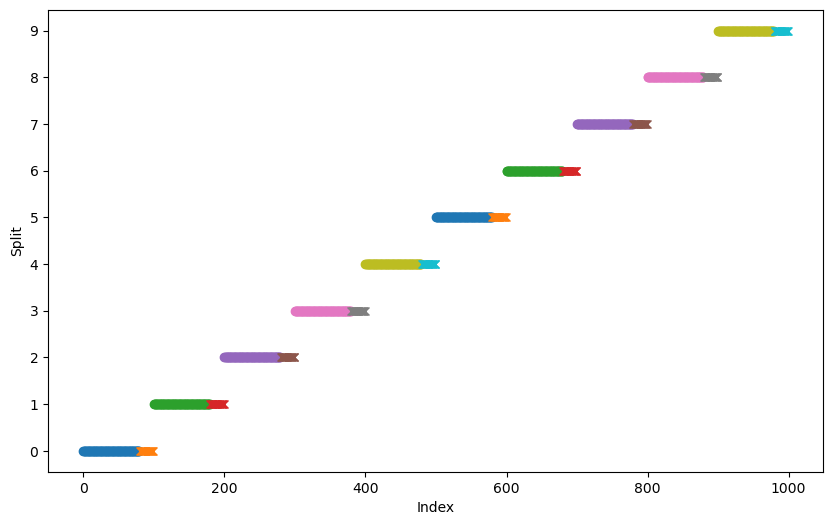

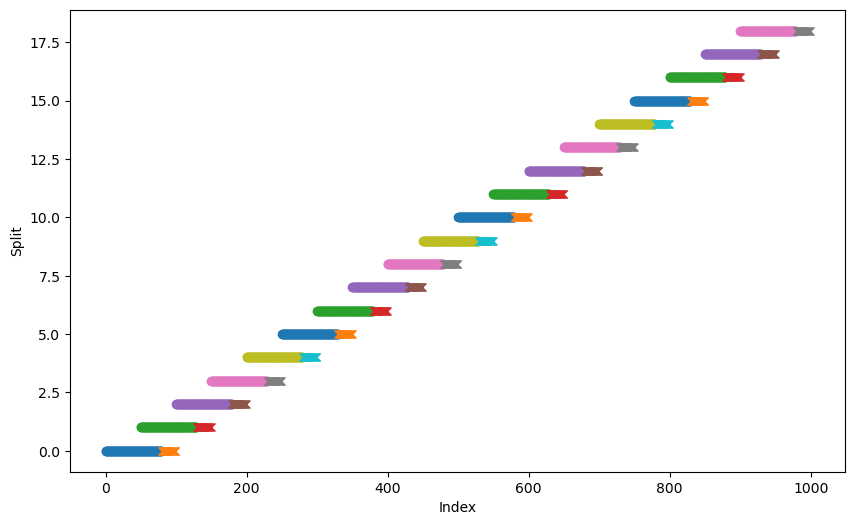

In [41]:
#test rollingbasistimeseriesplit

#create index  
indexes = np.arange(1000)

#split data
tscv = BlockingTimeSeriesSplit(n_splits=10)
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(indexes)):
    # Plot train and test indices
    ax.plot(train_index, np.zeros_like(train_index) + i, 'o')
    ax.plot(test_index, np.zeros_like(test_index) + i, 'x')

ax.set_yticks(range(10))
ax.set_xlabel("Index")
ax.set_ylabel("Split")
plt.show()


tscv = RollingBasisTimeSeriesSplit(step_size=50, fold_size=100)
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(indexes)):
    # Plot train and test indices
    ax.plot(train_index, np.zeros_like(train_index) + i, 'o')
    ax.plot(test_index, np.zeros_like(test_index) + i, 'x')

ax.set_xlabel("Index")
ax.set_ylabel("Split")
plt.show()




In [7]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

# class TimeSeriesDataset(Dataset):
#     def __init__(self, X1, X2, y):
#         self.X1 = X1  # Time series data
#         self.X2 = X2  # Motif indexes data
#         self.y = y    # Target values
    
#     def __len__(self):
#         return len(self.y)
    
#     def __getitem__(self, idx):
#         return self.X1[idx], self.X2[idx], self.y[idx]


In [ ]:
#TODO: check if this is how i want to deal with the x2 data
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer for processing X1
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layers
        self.fc = nn.Linear(hidden_size + X2.shape[1], output_size)
        
    def forward(self, X1, X2):
        
        # Forward propagate LSTM
        _, (h_n, _) = self.lstm(X1)

        # Concatenate with X2 (motif indexes)
        out = torch.cat((h_n[0], X2.float()), dim=1)  # Concatenate along the feature dimension

        # Pass through the final fully connected layer
        out = self.fc(out)
        return out

: 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error


# Model parameters
input_size = X1.shape[2]  # Number of features in X1
output_size = 1           

# Open the CSV file to log Optuna results
with open("optuna_tuning_results.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    # Write the header including columns for each fold's validation loss, average validation loss, test MAE, test RMSE, and their standard deviations
    writer.writerow(["trial_number", "learning_rate", "batch_size", "hidden_size", "num_layers",
                     "fold_1_val_loss", "fold_2_val_loss", "fold_3_val_loss", "fold_4_val_loss", "fold_5_val_loss",
                     "avg_validation_loss", "test_mae_mean", "test_mae_std", "test_rmse_mean", "test_rmse_std"])

    # Define the Optuna objective function
    def objective(trial):
        # Define hyperparameters to tune
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
        hidden_size = trial.suggest_categorical("hidden_size", [16, 32, 64, 128, 256])
        num_layers = 1
        batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])

        # Placeholder for fold validation losses
        fold_results = []
        
        # Placeholders for test MAE and RMSE for each fold
        test_mae_per_fold, test_rmse_per_fold = [], []

        # Cross-validation with BlockingTimeSeriesSplit
        for fold, (train_idx, test_idx) in enumerate(BlockingTimeSeriesSplit(n_splits=5).split(X1)):
            # Split train and test sets for each fold
            X1_train, X1_test = X1[train_idx], X1[test_idx]
            X2_train, X2_test = X2[train_idx], X2[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Split train into train and validation (80-20 split)
            val_index = int(0.8 * X1_train.shape[0])
            X1_train, X1_val = X1_train[:val_index], X1_train[val_index:]
            X2_train, X2_val = X2_train[:val_index], X2_train[val_index:]
            y_train, y_val = y_train[:val_index], y_train[val_index:]

            print(f"Fold {fold + 1} - Train size: {len(X1_train)}, Validation size: {len(X1_val)}, Test size: {len(X1_test)}")

            # Fit the MinMaxScaler on the training data only and transform train, val, and test data
            scaler_X1 = MinMaxScaler(feature_range=(0, 1))
            X1_train = torch.tensor(scaler_X1.fit_transform(X1_train.view(-1, X1_train.shape[-1])), dtype=torch.float32).view(X1_train.shape)
            X1_val = torch.tensor(scaler_X1.transform(X1_val.view(-1, X1_val.shape[-1])), dtype=torch.float32).view(X1_val.shape)
            X1_test = torch.tensor(scaler_X1.transform(X1_test.view(-1, X1_test.shape[-1])), dtype=torch.float32).view(X1_test.shape)

            # Create DataLoader for train, validation, and test sets
            train_dataset = TensorDataset(X1_train, X2_train, y_train)
            val_dataset = TensorDataset(X1_val, X2_val, y_val)
            test_dataset = TensorDataset(X1_test, X2_test, y_test)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False) #TODO: think about batch size for the validation set = 1  or size of the validation set
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #TODO:

            # Initialize model, loss function, and optimizer
            model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            
            # Training loop for the fold
            num_epochs = 200  
            for epoch in range(num_epochs):
                model.train()
                for batch_X1, batch_X2, batch_y in train_loader:
                    # Forward pass
                    outputs = model(batch_X1, batch_X2)
                    loss = criterion(outputs, batch_y)

                    # Backward pass and optimization
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            # Evaluate on validation set
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_X1, batch_X2, batch_y in val_loader:
                    outputs = model(batch_X1, batch_X2)
                    loss = criterion(outputs, batch_y)
                    val_loss += loss.item()
            avg_val_loss = val_loss / len(val_loader)
            fold_results.append(avg_val_loss)
        
            # Evaluate on test set for the current fold
            true_values, predictions = [], []
            with torch.no_grad():
                for batch_X1, batch_X2, batch_y in test_loader:
                    outputs = model(batch_X1, batch_X2)
                    predictions.extend(outputs.squeeze().cpu().numpy())
                    true_values.extend(batch_y.cpu().numpy())

            # Compute MAE and RMSE for this fold and store them
            fold_mae = mean_absolute_error(true_values, predictions)
            fold_rmse = root_mean_squared_error(true_values, predictions)
            test_mae_per_fold.append(fold_mae)
            test_rmse_per_fold.append(fold_rmse)

        # Calculate the mean and std of validation loss, test MAE, and test RMSE across folds
        mean_val_loss = np.mean(fold_results)
        mean_test_mae = np.mean(test_mae_per_fold)
        std_test_mae = np.std(test_mae_per_fold)
        mean_test_rmse = np.mean(test_rmse_per_fold)
        std_test_rmse = np.std(test_rmse_per_fold)

        # Log results for this trial
        writer.writerow([trial.number, learning_rate, batch_size, hidden_size, num_layers] + 
                        fold_results + [mean_val_loss, mean_test_mae, std_test_mae, mean_test_rmse, std_test_rmse])
        file.flush()  # Ensure each trial result is written immediately

        # Return the mean validation loss across folds for Optuna to optimize
        return mean_val_loss

    # Run the Optuna study
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100)

    # Save study with joblib
    import joblib
    joblib.dump(study, "synthetic_data_lstm_optuna.pkl")

    # Print the best hyperparameters and validation loss
    print("Best hyperparameters:", study.best_params)
    print("Best cross-validated validation loss:", study.best_value)


[I 2024-11-05 16:00:17,289] A new study created in memory with name: no-name-22e33762-670c-494a-9e8b-2adddf6303ee


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:01:07,368] Trial 0 finished with value: 5.7867065331467655 and parameters: {'learning_rate': 0.0006475571494384248, 'hidden_size': 256, 'batch_size': 64}. Best is trial 0 with value: 5.7867065331467655.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:02:00,484] Trial 1 finished with value: 16.32172530470195 and parameters: {'learning_rate': 4.532291940771066e-05, 'hidden_size': 256, 'batch_size': 32}. Best is trial 0 with value: 5.7867065331467655.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:02:03,137] Trial 2 finished with value: 223.22404908028525 and parameters: {'learning_rate': 1.9735663103154366e-05, 'hidden_size': 16, 'batch_size': 128}. Best is trial 0 with value: 5.7867065331467655.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:02:10,625] Trial 3 finished with value: 15.041160817430875 and parameters: {'learning_rate': 0.0001183823914331641, 'hidden_size': 32, 'batch_size': 32}. Best is trial 0 with value: 5.7867065331467655.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:02:31,288] Trial 4 finished with value: 11.635154450477998 and parameters: {'learning_rate': 0.0003790909954114751, 'hidden_size': 128, 'batch_size': 128}. Best is trial 0 with value: 5.7867065331467655.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:03:07,869] Trial 5 finished with value: 9.308522613786685 and parameters: {'learning_rate': 7.629869567628305e-05, 'hidden_size': 256, 'batch_size': 16}. Best is trial 0 with value: 5.7867065331467655.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:03:26,240] Trial 6 finished with value: 2.8845266163469576 and parameters: {'learning_rate': 0.0004428393126035259, 'hidden_size': 128, 'batch_size': 16}. Best is trial 6 with value: 2.8845266163469576.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:04:13,511] Trial 7 finished with value: 23.877668543424406 and parameters: {'learning_rate': 2.4320552434266004e-05, 'hidden_size': 256, 'batch_size': 64}. Best is trial 6 with value: 2.8845266163469576.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:04:34,037] Trial 8 finished with value: 4.914096232078134 and parameters: {'learning_rate': 0.000957184925703725, 'hidden_size': 128, 'batch_size': 128}. Best is trial 6 with value: 2.8845266163469576.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:04:45,416] Trial 9 finished with value: 15.146274550167437 and parameters: {'learning_rate': 7.343298053060465e-05, 'hidden_size': 32, 'batch_size': 16}. Best is trial 6 with value: 2.8845266163469576.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:04:59,947] Trial 10 finished with value: 6.789895844164481 and parameters: {'learning_rate': 0.0002384688134719796, 'hidden_size': 64, 'batch_size': 16}. Best is trial 6 with value: 2.8845266163469576.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:05:20,444] Trial 11 finished with value: 8.106459725145672 and parameters: {'learning_rate': 0.0009657460917117259, 'hidden_size': 128, 'batch_size': 128}. Best is trial 6 with value: 2.8845266163469576.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:05:40,979] Trial 12 finished with value: 11.890339072298355 and parameters: {'learning_rate': 0.0003105220894884938, 'hidden_size': 128, 'batch_size': 128}. Best is trial 6 with value: 2.8845266163469576.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:05:59,282] Trial 13 finished with value: 1.104001708886238 and parameters: {'learning_rate': 0.0009658948610562661, 'hidden_size': 128, 'batch_size': 16}. Best is trial 13 with value: 1.104001708886238.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:06:17,592] Trial 14 finished with value: 6.565388315108581 and parameters: {'learning_rate': 0.00015989875959688982, 'hidden_size': 128, 'batch_size': 16}. Best is trial 13 with value: 1.104001708886238.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:06:32,126] Trial 15 finished with value: 0.7072049657202523 and parameters: {'learning_rate': 0.0005219633905712332, 'hidden_size': 64, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:06:46,673] Trial 16 finished with value: 0.890847687453688 and parameters: {'learning_rate': 0.0005390812529121449, 'hidden_size': 64, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:07:01,215] Trial 17 finished with value: 7.013924430902035 and parameters: {'learning_rate': 0.00019770148474014998, 'hidden_size': 64, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:07:15,755] Trial 18 finished with value: 2.354982724159771 and parameters: {'learning_rate': 0.0005965228213924391, 'hidden_size': 64, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:07:24,370] Trial 19 finished with value: 154.13557729475716 and parameters: {'learning_rate': 1.1560960024366613e-05, 'hidden_size': 64, 'batch_size': 32}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:07:32,454] Trial 20 finished with value: 8.225981486587234 and parameters: {'learning_rate': 0.0005027848605274086, 'hidden_size': 64, 'batch_size': 64}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:07:42,277] Trial 21 finished with value: 1.229512004889267 and parameters: {'learning_rate': 0.0007793994291932986, 'hidden_size': 16, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:07:56,832] Trial 22 finished with value: 3.9144218023198034 and parameters: {'learning_rate': 0.00030452956548450037, 'hidden_size': 64, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:08:11,385] Trial 23 finished with value: 3.6056850466030204 and parameters: {'learning_rate': 0.00048135511895798717, 'hidden_size': 64, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:08:25,950] Trial 24 finished with value: 2.741352082927037 and parameters: {'learning_rate': 0.0007087510393720734, 'hidden_size': 64, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:08:37,367] Trial 25 finished with value: 7.2653668480417695 and parameters: {'learning_rate': 0.0002714139925738574, 'hidden_size': 32, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:08:47,178] Trial 26 finished with value: 10.544130437385652 and parameters: {'learning_rate': 0.00014346287051416576, 'hidden_size': 16, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:09:01,745] Trial 27 finished with value: 1.4715567087243282 and parameters: {'learning_rate': 0.0009824599250897546, 'hidden_size': 64, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:09:09,775] Trial 28 finished with value: 8.04734220284776 and parameters: {'learning_rate': 0.0004175278098299727, 'hidden_size': 64, 'batch_size': 64}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:09:28,267] Trial 29 finished with value: 1.4065317121356515 and parameters: {'learning_rate': 0.0006449330385547922, 'hidden_size': 128, 'batch_size': 32}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:09:32,063] Trial 30 finished with value: 14.384939436102286 and parameters: {'learning_rate': 0.0002095053130962091, 'hidden_size': 16, 'batch_size': 64}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:09:41,889] Trial 31 finished with value: 2.7704979046561014 and parameters: {'learning_rate': 0.0007223647972130128, 'hidden_size': 16, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:09:51,706] Trial 32 finished with value: 3.494710518351499 and parameters: {'learning_rate': 0.0007575565598101959, 'hidden_size': 16, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:10:01,523] Trial 33 finished with value: 2.4250401112025175 and parameters: {'learning_rate': 0.0005520274161826905, 'hidden_size': 16, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:10:33,831] Trial 34 finished with value: 3.8519135828860556 and parameters: {'learning_rate': 0.0003576423564670069, 'hidden_size': 256, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:10:39,756] Trial 35 finished with value: 4.664501736619786 and parameters: {'learning_rate': 0.000816086424944062, 'hidden_size': 16, 'batch_size': 32}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:10:51,145] Trial 36 finished with value: 19.48725530760973 and parameters: {'learning_rate': 4.050167279494675e-05, 'hidden_size': 32, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:11:24,145] Trial 37 finished with value: 1.3329980804348076 and parameters: {'learning_rate': 0.0005655780979243278, 'hidden_size': 256, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:11:42,347] Trial 38 finished with value: 3.8578965421523237 and parameters: {'learning_rate': 0.00037454538878147256, 'hidden_size': 128, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:11:48,239] Trial 39 finished with value: 41.08196307008058 and parameters: {'learning_rate': 9.653615048497565e-05, 'hidden_size': 16, 'batch_size': 32}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:11:55,345] Trial 40 finished with value: 6.463998997982206 and parameters: {'learning_rate': 0.0008337368909006861, 'hidden_size': 64, 'batch_size': 128}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:12:30,777] Trial 41 finished with value: 2.2690443194392014 and parameters: {'learning_rate': 0.0005268768079911835, 'hidden_size': 256, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:13:03,727] Trial 42 finished with value: 0.8891852172228092 and parameters: {'learning_rate': 0.000627478399828463, 'hidden_size': 256, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:13:36,584] Trial 43 finished with value: 2.5325248224352905 and parameters: {'learning_rate': 0.00040973795980830507, 'hidden_size': 256, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:14:08,937] Trial 44 finished with value: 0.7816609767836655 and parameters: {'learning_rate': 0.0006334299683884136, 'hidden_size': 256, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:14:42,558] Trial 45 finished with value: 3.6810812848333105 and parameters: {'learning_rate': 0.0003235999378894927, 'hidden_size': 256, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:15:30,039] Trial 46 finished with value: 1.8345557045498435 and parameters: {'learning_rate': 0.0006168926730716198, 'hidden_size': 256, 'batch_size': 64}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:16:13,664] Trial 47 finished with value: 6.995389887516479 and parameters: {'learning_rate': 0.00046246712123239694, 'hidden_size': 256, 'batch_size': 128}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:16:47,876] Trial 48 finished with value: 3.902574519940052 and parameters: {'learning_rate': 0.0002510715674832466, 'hidden_size': 256, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:17:06,187] Trial 49 finished with value: 13.352767785815905 and parameters: {'learning_rate': 4.920315919821622e-05, 'hidden_size': 128, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:17:17,578] Trial 50 finished with value: 1.1667329988142732 and parameters: {'learning_rate': 0.0009697775532442689, 'hidden_size': 32, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:17:28,940] Trial 51 finished with value: 0.8259352752893327 and parameters: {'learning_rate': 0.0009988831727353992, 'hidden_size': 32, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:17:40,320] Trial 52 finished with value: 1.2828171332443037 and parameters: {'learning_rate': 0.0008549646767652396, 'hidden_size': 32, 'batch_size': 16}. Best is trial 15 with value: 0.7072049657202523.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:17:51,713] Trial 53 finished with value: 0.5518494630389326 and parameters: {'learning_rate': 0.0006452590841337331, 'hidden_size': 32, 'batch_size': 16}. Best is trial 53 with value: 0.5518494630389326.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:18:03,096] Trial 54 finished with value: 1.668137224439833 and parameters: {'learning_rate': 0.0006428881531990511, 'hidden_size': 32, 'batch_size': 16}. Best is trial 53 with value: 0.5518494630389326.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:18:14,484] Trial 55 finished with value: 3.3587958138669975 and parameters: {'learning_rate': 0.00048396186759074326, 'hidden_size': 32, 'batch_size': 16}. Best is trial 53 with value: 0.5518494630389326.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:18:18,214] Trial 56 finished with value: 11.364489925505016 and parameters: {'learning_rate': 0.0006517637049322929, 'hidden_size': 32, 'batch_size': 128}. Best is trial 53 with value: 0.5518494630389326.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:18:29,589] Trial 57 finished with value: 3.586860277018096 and parameters: {'learning_rate': 0.00035425389164011917, 'hidden_size': 32, 'batch_size': 16}. Best is trial 53 with value: 0.5518494630389326.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:18:44,182] Trial 58 finished with value: 70.00373364081285 and parameters: {'learning_rate': 1.1216684346390997e-05, 'hidden_size': 64, 'batch_size': 16}. Best is trial 53 with value: 0.5518494630389326.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:18:51,717] Trial 59 finished with value: 669.2600811184996 and parameters: {'learning_rate': 1.8431358521131464e-05, 'hidden_size': 32, 'batch_size': 32}. Best is trial 53 with value: 0.5518494630389326.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:19:26,744] Trial 60 finished with value: 5.710356422224994 and parameters: {'learning_rate': 0.00018391309846319638, 'hidden_size': 256, 'batch_size': 16}. Best is trial 53 with value: 0.5518494630389326.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:19:44,967] Trial 61 finished with value: 0.6733832426978614 and parameters: {'learning_rate': 0.0009965249204506705, 'hidden_size': 128, 'batch_size': 16}. Best is trial 53 with value: 0.5518494630389326.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36
Fold 4 - Train size: 113, Validation size: 29, Test size: 36
Fold 5 - Train size: 113, Validation size: 29, Test size: 36


[I 2024-11-05 16:20:03,169] Trial 62 finished with value: 0.5896721749224274 and parameters: {'learning_rate': 0.0008437681711468768, 'hidden_size': 128, 'batch_size': 16}. Best is trial 53 with value: 0.5518494630389326.


Fold 1 - Train size: 113, Validation size: 29, Test size: 36
Fold 2 - Train size: 113, Validation size: 29, Test size: 36
Fold 3 - Train size: 113, Validation size: 29, Test size: 36


In [ ]:
113+29+36

178

In [2]:
178*5

890